In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import shap

Import data prepared in previous steps (only data for 2018 survey, full time employment, and removed outliers) and used for all machine learning models. The target is hourly rate and predictors are economic sector (nace), company size (esize_class), gender, age class, profession (lpk), education. All these are categorical variables. Single numerical variable is experience in years.

In [3]:
data = pd.read_csv('../Data/LT_DU_data_for_ML.csv') 
data.head()

,nace,esize_class,gender,age_class,lpk,education,experience,target
0,C,1_49,M,40-49,p721,G2,13,8.20
1,C,1_49,F,40-49,p334,G2,0,2.51
2,M,50_249,F,40-49,p522,G2,18,2.19
3,M,50_249,F,40-49,p522,G2,12,2.19
4,M,50_249,F,14-29,p522,G2,0,2.19


One fifth of records is kept for testing of models.

In [4]:
y = data['target']
X = data.drop(columns='target')

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=0)

print('Dataset lengths:', 'train', len(y_train), ', test', len(y_test))

Dataset lengths: train 26114 , test 6529


# Model and predictions

## Initial model

Initial model to test pipline and preprocessing steps. Numerical feature is scaled with [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) and categorical features are encoded using [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from xgboost import XGBRegressor

numeric_preprocessor = Pipeline(steps=[("scaler", StandardScaler())])

categorical_preprocessor = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer(
    [
        ("categorical", categorical_preprocessor, ['nace', 'esize_class', 'gender', 'age_class', 'lpk', 'education']),
        ("numerical", numeric_preprocessor, ['experience'])
    ]
)

model = Pipeline([('prep', preprocessor), ('regr', XGBRegressor())])
model.fit(X=X_train, y=y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['nace', 'esize_class',
                                                   'gender', 'age_class', 'lpk',
                                                   'education']),
                                                 ('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['experience'])])),
                ('regr',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              co...
                              feature_types=None, gamma=0, gpu_id=-1,
                              grow_policy='depthwise', importance_type=None,
                              interaction_constraints='',
                              learning_rate=0.300000012, max_bin=256,
                              max_cat_threshold=64, max_cat_to_onehot=4,
                              max_delta_step=0, max_depth=6, max_leaves=0,
                              min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=0, num_parallel_tree=1, predictor='auto',
                              random_state=0, ...))])

Function to print model prediction RMSE and R2

In [6]:
def print_model_rmse_r2(model, X_train, y_train, X_test, y_test):
    """ 
    Function to print model prediction RMSE and R2
    for train and test datasets
        Parameters:
        model - model to evaluate
        X_train - train features
        y_train - train target 
        X_test - test features
        y_test - test target
    """
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred)).round(3)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred)).round(3)

    r2_train = r2_score(y_train, y_train_pred).round(3)
    r2_test = r2_score(y_test, y_test_pred).round(3)

    print('Train: RMSE=', rmse_train, ' R2=', r2_train,
        '\nTest: RMSE=', rmse_test, ' R2=', r2_test)

RMSE and R2 of initial model predicions for train and test datasets

In [7]:
print_model_rmse_r2(model, X_train, y_train, X_test, y_test)

Train: RMSE= 1.425  R2= 0.687 
Test: RMSE= 1.651  R2= 0.578


## Randomized Search CV

Randomized cross validation was used to tune model. Randomized search used to quickly explore parameter space and test if tuning of hyperparameters potentially can provide substantial gains over initial model.

In [8]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
model = Pipeline([('prep', preprocessor), ('regr', XGBRegressor())])

grid = {'regr__max_depth':np.arange(5, 15, dtype=int),
        'regr__eta': np.linspace(0.05, 0.55, 9),
        'regr__gamma': np.linspace(1,  3,  9),
        'regr__min_child_weight': np.arange(1, 6, dtype=int),
        'regr__subsample': np.linspace(0.3, 1, 9), 
        'regr__colsample_bytree': np.linspace(0.3,  1,  9),
        'regr__alpha': np.linspace(0,  1,  9),
        'regr__lambda' : [1, 5, 10, 20],
        'regr__learning_rate': np.linspace(0.05,  0.2,  4)
         }
search = RandomizedSearchCV(model, grid, scoring='neg_root_mean_squared_error', n_iter = 150, cv=cv, n_jobs=-1)
results = search.fit(X=X_train,y=y_train)

results_pd = pd.DataFrame(results.cv_results_)
results_pd.filter(regex='rank|regr|mean_test_score|std_test_score',axis=1).sort_values('rank_test_score').head().T

,144,147,7,99,66
param_regr__subsample,0.825,1.0,0.9125,1.0,0.825
param_regr__min_child_weight,2,2,1,2,2
param_regr__max_depth,14,13,12,12,14
param_regr__learning_rate,0.15,0.1,0.15,0.1,0.2
param_regr__lambda,20,5,20,5,20
param_regr__gamma,2.5,1.25,2.75,2.75,1.5
param_regr__eta,0.55,0.05,0.3,0.1125,0.2375
param_regr__colsample_bytree,0.3875,0.3875,0.3875,0.3875,0.3
param_regr__alpha,0.25,0.5,0.125,0.875,0.625
mean_test_score,-1.665551,-1.665879,-1.66618,-1.669277,-1.670375


In [9]:
best_model=results.best_estimator_
best_model

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['nace', 'esize_class',
                                                   'gender', 'age_class', 'lpk',
                                                   'education']),
                                                 ('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['experience'])])),
                ('regr',
                 XGBRegressor(alpha=0.25, base_score=0.5, booster='gbtree',
                              callba...
                              eval_metric=None, feature_types=None, gamma=2.5,
                              gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              lambda=20, learning_rate=0.15000000000000002,
                              max_bin=256, max_cat_threshold=64,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=14, max_leaves=0, min_child_weight=2,
                              missing=nan, monotone_constraints='()',
                              n_estimators=100, n_jobs=0, ...))])

In [10]:
print_model_rmse_r2(best_model, X_train, y_train, X_test, y_test)

Train: RMSE= 1.478  R2= 0.663 
Test: RMSE= 1.626  R2= 0.59


Variability of parameter values is significant for five best iterations and performance gain over untuned initial model is marginal. The model with parameters from best iteration will be used for further analysis.

## Feature importance

We tested the feature importance using native XGBoost and [SHAP](https://shap.readthedocs.io/en/latest/) methods.

### XGBoost

In [11]:
best_regr = best_model.named_steps["regr"]
feature_importances = best_regr.feature_importances_

prep = best_model.named_steps["prep"]
feature_names = prep.get_feature_names_out()

importances = pd.DataFrame({'importance': feature_importances }, index=feature_names )
importances.sort_values('importance', ascending=False)

,importance
categorical__education_G2,0.068534
categorical__lpk_p251,0.067361
categorical__education_G1,0.039182
categorical__lpk_p122,0.039133
categorical__lpk_p911,0.035332
...,...
categorical__lpk_p713,0.001183
categorical__lpk_p754,0.001181
categorical__lpk_p211,0.001098
categorical__lpk_p831,0.000768


### SHAP

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


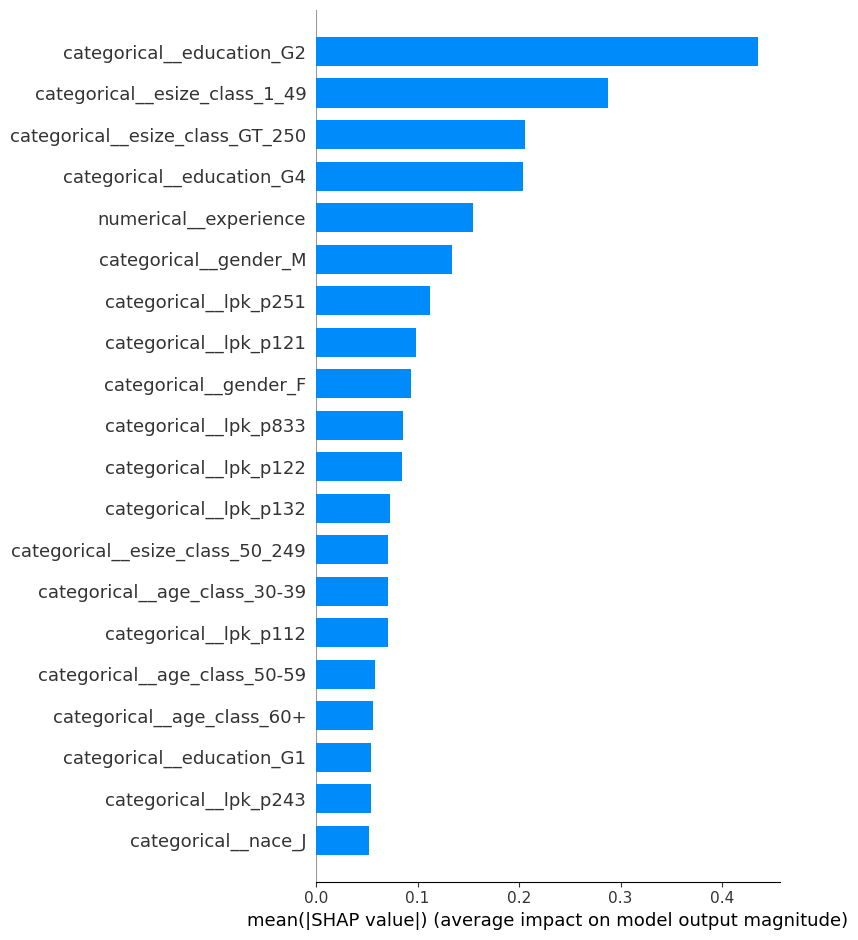

In [12]:
explainer = shap.TreeExplainer(best_regr, feature_names=feature_names)
shap_values = explainer(prep.transform(X_test))
shap.summary_plot(shap_values, plot_type="bar");

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


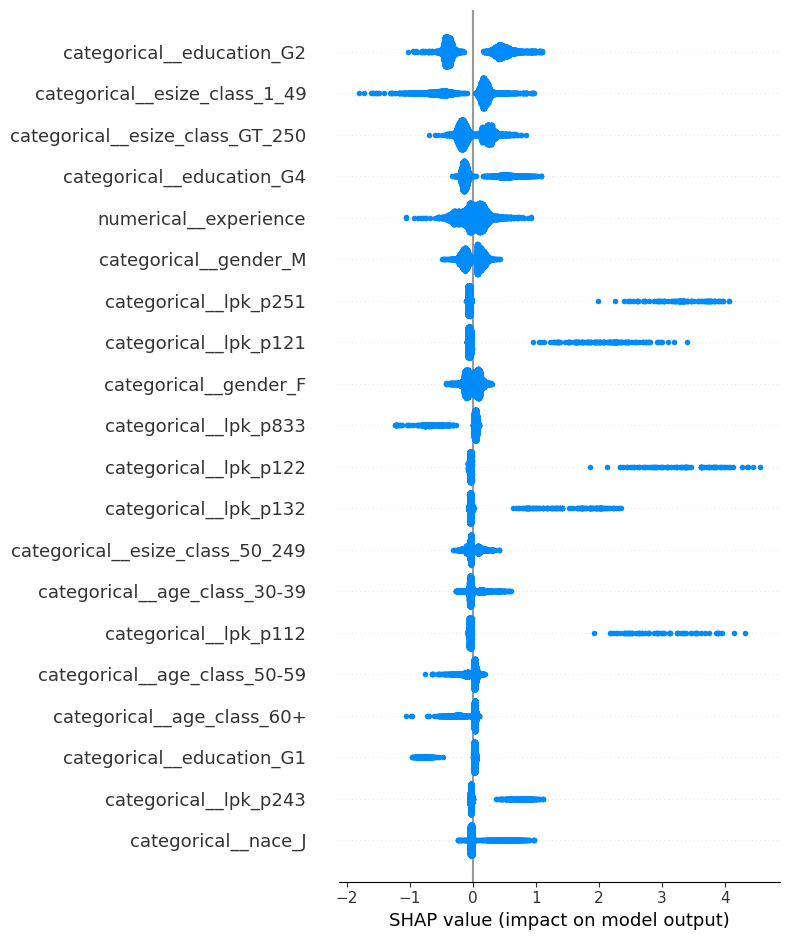

In [13]:
shap_values = shap.TreeExplainer(best_model['regr']).shap_values(prep.transform(X_test))
shap.summary_plot(shap_values, feature_names=feature_names );

# Model (Pipline) Serialization 

In [14]:
import joblib
joblib.dump(best_model, './Models/XGBoost_model.joblib')

['./Models/XGBoost_model.joblib']